In [84]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import itertools    
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from sklearn.metrics import confusion_matrix

## Read images

In [85]:
import pathlib

data_dir = pathlib.Path('./dataset')


image_count = len(list(data_dir.glob('*/*.*')))
print("Total no of images =", image_count)




Total no of images = 8385


## Split data

In [86]:


batch_size = 64
img_height = 100
img_width = 100



In [87]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  #color_mode="grayscale",
  validation_split=0.1,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 8384 files belonging to 15 classes.
Using 7546 files for training.


In [88]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  #color_mode="grayscale",
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 8384 files belonging to 15 classes.
Using 1676 files for validation.


In [89]:
class_names = train_ds.class_names

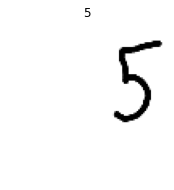

In [90]:
plt.figure(figsize=(10, 10))
for images, labels in val_ds.take(1):
  for i in range(1):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [91]:
num_classes = 16
img_channels = 3

model = Sequential([
  layers.Conv2D(16, 3, padding='same', activation='relu',input_shape=(img_height, img_width, img_channels)),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes),
  #keras.layers.Dense(num_classes, activation='softmax')
])

In [92]:


model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])



In [93]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 100, 100, 16)      448       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 50, 50, 16)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 50, 50, 32)        4640      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 25, 25, 64)        18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 12, 12, 64)       

In [94]:
epochs = 3
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/3
118/118 [==============================] - 53s 444ms/step - loss: 31.8198 - accuracy: 0.2606 - val_loss: 0.7789 - val_accuracy: 0.7601
Epoch 2/3
118/118 [==============================] - 51s 426ms/step - loss: 0.8001 - accuracy: 0.7444 - val_loss: 0.4061 - val_accuracy: 0.8777
Epoch 3/3
118/118 [==============================] - 50s 423ms/step - loss: 0.4162 - accuracy: 0.8714 - val_loss: 0.3335 - val_accuracy: 0.9081


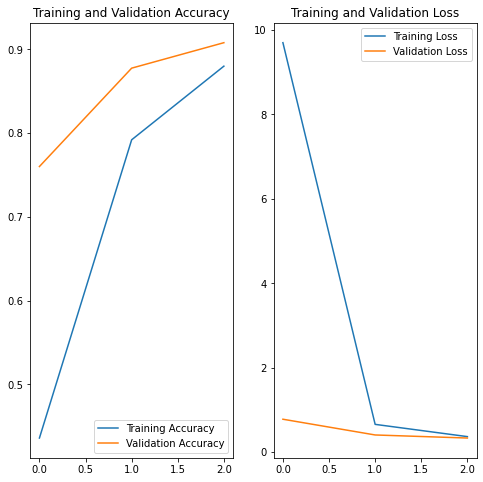

In [95]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


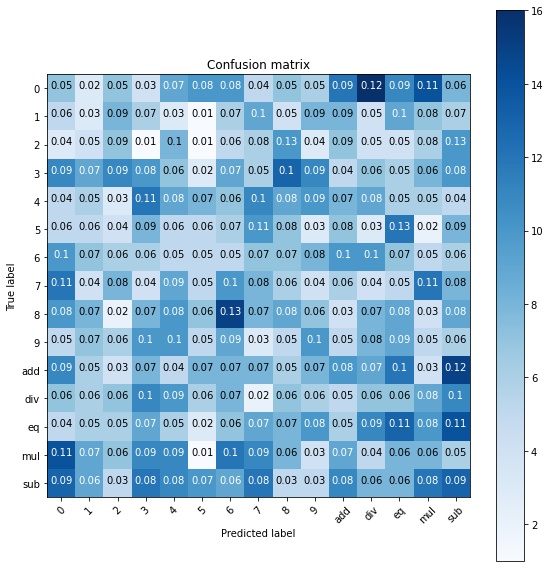

In [96]:
def plot_confusion_matrix(cm, class_names):
  """
  Returns a matplotlib figure containing the plotted confusion matrix.

  Args:
    cm (array, shape = [n, n]): a confusion matrix of integer classes
    class_names (array, shape = [n]): String names of the integer classes
  """
  figure = plt.figure(figsize=(8, 8))
  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
  plt.title("Confusion matrix")
  plt.colorbar()
  tick_marks = np.arange(len(class_names))
  plt.xticks(tick_marks, class_names, rotation=45)
  plt.yticks(tick_marks, class_names)

  # Compute the labels from the normalized confusion matrix.
  labels = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)

  # Use white text if squares are dark; otherwise black.
  threshold = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    color = "white" if cm[i, j] > threshold else "black"
    plt.text(j, i, labels[i, j], horizontalalignment="center", color=color)

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  return figure

y_pred = model.predict(val_ds)
y_pred = tf.nn.softmax(y_pred)
predicted_categories = tf.argmax(y_pred, axis=1)
true_categories = tf.concat([y for x, y in val_ds], axis=0)
cm = confusion_matrix(predicted_categories, true_categories)
figure = plot_confusion_matrix(cm, class_names)

In [100]:
 test_image_path = "eq.png"
 test_image = PIL.Image.open(test_image_path)

 img = keras.preprocessing.image.load_img(
     test_image_path, target_size=(img_height, img_width)
 )
 img_array = keras.preprocessing.image.img_to_array(img)
 img_array = tf.expand_dims(img_array, 0)  #Create a batch

 predictions = model.predict(img_array)
 score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to eq with a 83.42 percent confidence.
